### Vision transformer applied for weather variables predictions 
#### The model is adapted from two sources: 
* climatelearn         https://climatelearn.readthedocs.io/en/latest/user-guide/models.html
* pytorch-image-models https://github.com/rwightman/pytorch-image-models/blob/main/timm/models/vision_transformer.py

#### The data used correspond to 
* WeatherBech (coarser resolution from ERA5)

In [1]:
import torch as T
import torch.nn as nn
#from torchtext import data, datasets
#from torchtext.vocab import Vocab
import torch.optim as optim
import time
import copy
import torch
import torch.nn.functional as F
from torchsummary import summary
import math

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import math
import datetime
from collections import OrderedDict

# Custom imports
from utils.datagenerator import *
from utils.util_data import * 
from utils.metrics import *
from utils.helpers import *
from utils.drop import *

/storage/homefs/no21h426/.conda/envs/pyTT/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-27 13:51:18.289359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 13:51:36.761297: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software.el7/software/cuDNN/8.2.1.32-CUDA-11.3.1/lib:/software.el7/software/CUDA/11.3.1/nvvm/lib64:/software.el7/software/CU

In [2]:
print("Cuda Avaliable :", torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Cuda Avaliable : True
cuda


In [3]:
# open data from WeatherBench
DATADIR = '/storage/homefs/no21h426/WeatherBench-master/data/WeatherBench/5.625deg/'
# Load the entire dataset
z500 = xr.open_mfdataset(f'{DATADIR}geopotential/*.nc', combine='by_coords').z
t850 = xr.open_mfdataset(f'{DATADIR}temperature/*.nc', combine='by_coords').t.drop('level')
ds = xr.merge([z500, t850])

In [4]:
# only load a subset of the training data
ds_train = ds.sel(time=slice('2015', '2016'))  
ds_test = ds.sel(time=slice('2017', '2018'))

In [5]:
# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None, 't': None})
lead_time =1
bs = 32
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('2015', '2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM


In [6]:
X,y=dg_train[0]
print(X.shape)
Xt = torch.as_tensor(X)
print(Xt.shape)

(32, 2, 32, 64)
torch.Size([32, 2, 32, 64])


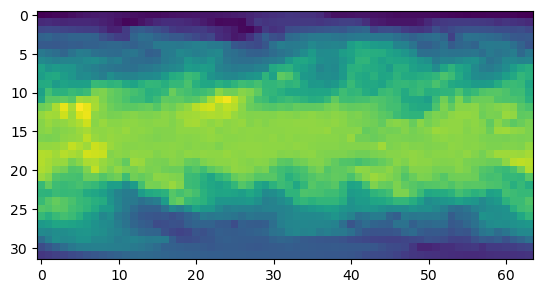

In [7]:
plt.imshow(X[0,1,:,:])

In [8]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(
            self,
            in_features,
            hidden_features=None,
            out_features=None,
            act_layer=nn.GELU,
            bias=True,
            drop=0.,
            use_conv=False,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        bias = to_2tuple(bias)
        drop_probs = to_2tuple(drop)
        linear_layer = partial(nn.Conv2d, kernel_size=1) if use_conv else nn.Linear

        self.fc1 = linear_layer(in_features, hidden_features, bias=bias[0])
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop_probs[0])
        self.fc2 = linear_layer(hidden_features, out_features, bias=bias[1])
        self.drop2 = nn.Dropout(drop_probs[1])

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

In [9]:

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class LayerScale(nn.Module):
    def __init__(self, dim, init_values=1e-5, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.gamma = nn.Parameter(init_values * torch.ones(dim))

    def forward(self, x):
        return x.mul_(self.gamma) if self.inplace else x * self.gamma
        

class Block(nn.Module):

    def __init__(
            self,
            dim,
            num_heads,
            mlp_ratio=4.,
            qkv_bias=False,
            drop=0.,
            attn_drop=0.,
            init_values=None,
            drop_path=0.,
            act_layer=nn.GELU,
            norm_layer=nn.LayerNorm
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, drop=drop)
        self.ls1 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path1 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)

        self.ls2 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        self.drop_path2 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))))
        x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
        return x


In [10]:
class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    def __init__(
            self,
            img_size=224,
            patch_size=16,
            in_chans=3,
            embed_dim=768,
            norm_layer=None,
            flatten=True,
            bias=True,
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size, bias=bias)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
       # assert(H == self.img_size[0], f"Input image height ({H}) doesn't match model ({self.img_size[0]}).")
       # assert(W == self.img_size[1], f"Input image width ({W}) doesn't match model ({self.img_size[1]}).")
        # need to add
        #x = torch.as_tensor(x)
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        x = self.norm(x)
        return x


In [11]:
# patchE = PatchEmbed( [32,64], [16,16], 2, 64 )

In [12]:
# test
# test = torch.randn(2, 2, 32, 64)
# pt = patchE(test)

In [13]:
# --------------------------------------------------------
# 2D sine-cosine position embedding
# References:
# Transformer: https://github.com/tensorflow/models/blob/master/official/nlp/transformer/model_utils.py
# MoCo v3: https://github.com/facebookresearch/moco-v3
# --------------------------------------------------------
def get_2d_sincos_pos_embed(embed_dim, grid_size_h, grid_size_w, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size_h, dtype=np.float32)
    grid_w = np.arange(grid_size_w, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size_h, grid_size_w])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [14]:
import warnings
from torch.nn.init import _calculate_fan_in_and_fan_out
# Ref.:https://github.com/rwightman/pytorch-image-models/


def _trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    # Values are generated by using a truncated uniform distribution and
    # then using the inverse CDF for the normal distribution.
    # Get upper and lower cdf values
    l = norm_cdf((a - mean) / std)
    u = norm_cdf((b - mean) / std)

    # Uniformly fill tensor with values from [l, u], then translate to
    # [2l-1, 2u-1].
    tensor.uniform_(2 * l - 1, 2 * u - 1)

    # Use inverse cdf transform for normal distribution to get truncated
    # standard normal
    tensor.erfinv_()

    # Transform to proper mean, std
    tensor.mul_(std * math.sqrt(2.))
    tensor.add_(mean)

    # Clamp to ensure it's in the proper range
    tensor.clamp_(min=a, max=b)
    return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    NOTE: this impl is similar to the PyTorch trunc_normal_, the bounds [a, b] are
    applied while sampling the normal with mean/std applied, therefore a, b args
    should be adjusted to match the range of mean, std args.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    with torch.no_grad():
        return _trunc_normal_(tensor, mean, std, a, b)

In [15]:
# from climate_learn
class VisionTransformer(nn.Module):


    def __init__(
        self,
        img_size,
        patch_size,
        in_vars, 
        out_vars,
        drop_path=0.1,
        drop_rate=0.1,
        learn_pos_emb=False,
        upsampling=1,
        embed_dim=128,
        depth=12,
        decoder_depth=8,
        num_heads=16,
        mlp_ratio=4.0,
        weight_init = '',
    ):
    
        super().__init__()

        self.img_size = img_size
        self.upsampling = upsampling

        self.img_out_size = [img_size[0] * upsampling, img_size[1] * upsampling]
        self.n_channels = in_vars
        self.patch_size = patch_size

        self.in_vars = in_vars
        self.out_vars = out_vars



        # --------------------------------------------------------------------------
        # ViT encoder
        self.patch_embed = PatchEmbed(
            img_size, patch_size, in_vars, embed_dim
        )
        self.num_patches = self.patch_embed.num_patches  # 128

        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches, embed_dim), requires_grad=learn_pos_emb
        )  # fixed sin-cos embedding
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [
            x.item() for x in torch.linspace(0, drop_path, depth)
        ]  # stochastic depth decay rule
           
        self.blocks = nn.ModuleList(
            [
                 Block(
                    embed_dim,
                    num_heads,
                    mlp_ratio,
                    qkv_bias=True,
                    drop_path=dpr[i],
                    norm_layer=nn.LayerNorm,
                    drop=drop_rate,
                )
                for i in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim)

        # --------------------------------------------------------------------------
        # Up to here, it's like I did before
        # Next part introduces further changes 
        # --------------------------------------------------------------------------
        # ViT prediction head
        self.head = nn.ModuleList()
        for i in range(decoder_depth):
            self.head.append(nn.Linear(embed_dim, embed_dim))
            self.head.append(nn.GELU())
        self.head.append(
            nn.Linear(embed_dim, self.out_vars * patch_size**2 * upsampling**2)
        )
        self.head = nn.Sequential(*self.head)
        # --------------------------------------------------------------------------
        if weight_init != 'skip':
            self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(
            self.pos_embed.shape[-1],
            int(self.img_size[0] / self.patch_size),
            int(self.img_size[1] / self.patch_size),
            cls_token=False,
        )
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        # w = self.patch_embed.proj.weight.data
        # trunc_normal_(w.view([w.shape[0], -1]), std=0.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, C, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_size
        assert imgs.shape[2] % p == 0 and imgs.shape[3] % p == 0

        h = self.img_size[0] // p
        w = self.img_size[1] // p
        c = self.in_vars
        x = imgs.reshape(shape=(imgs.shape[0], c, h, p, w, p))
        x = torch.einsum("nchpwq->nhwpqc", x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * c))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_size * self.upsampling
        c = self.out_vars
        h = self.img_out_size[0] // p
        w = self.img_out_size[1] // p
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum("nhwpqc->nchpwq", x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, w * p))
        return imgs

    def forward_encoder(self, x: torch.Tensor):
        """
        x: B, C, H, W
        """
        # embed patches
        x = self.patch_embed(x)  # B, L, D

        # add pos embed
        x = x + self.pos_embed

        # dropout
        x = self.pos_drop(x)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x

    #def forward_loss(self, y, pred, out_variables, metric, lat):  # metric is a list
    def forward_loss(self, pred):  # metric is a list
        """
        y: [N, 3, H, W]
        pred: [N, L, p*p*3]
        """
        pred = self.unpatchify(pred)
        return pred
        #return ([m(pred, y, out_variables, lat=lat) for m in metric], pred)

   # def forward(self, x, y):
       # def forward(self, x, y, out_variables, metric, lat):
   #     embeddings = self.forward_encoder(x)  # B, L, D
   #     preds = self.head(embeddings)
       # print(preds.shape)
   #     loss = self.forward_loss(preds)
        
        # loss, preds = self.forward_loss(y, preds, out_variables, metric, lat)
   #     return preds
    def forward(self, x):
       # def forward(self, x, y, out_variables, metric, lat):
        embeddings = self.forward_encoder(x)  # B, L, D
        x = self.head(embeddings)
        x = self.unpatchify(x)
        return x
    

    def predict(self, x):
        with torch.no_grad():
            embeddings = self.forward_encoder(x)
            pred = self.head(embeddings)
        return self.unpatchify(pred)


In [16]:
torch.cuda.empty_cache()

In [17]:
# Test
model = VisionTransformer(img_size=[32, 64], embed_dim=1024, patch_size=2, in_vars = 2, out_vars = 2, depth=8, upsampling=1).to(device)
#x, y = torch.randn(2, 2, 32, 64), torch.randn(2, 2, 32, 64)

/scratch/local/51273287/ipykernel_3737/2479062441.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  omega = np.arange(embed_dim // 2, dtype=np.float)


In [23]:
Xt = Xt.to(device)

In [24]:
Xt.shape

torch.Size([32, 2, 32, 64])

In [25]:
#pred = model.predict(Xt).to(device)
#pred.shape

In [26]:
#yt = torch.as_tensor(y).to(device)

In [27]:
# Train 
#learning_rate = 0.0008
#weight_decay = 0.001
learning_rate =  0.0001
weight_decay = 1e-4
batch_size = 32
num_epochs = 10
#warmup_start_lr = 1e-8
#eta_min = 1e-8

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay = weight_decay)
#optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate, weight_decay = weight_decay)


In [28]:
train_loss = 0.0
val_loss = 0.0

trainingEpoch_loss = []
validationEpoch_loss = []

size = len(dg_train.data)

  # Run the training loop
for epoch in range(0, num_epochs): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = []
    
    # Iterate over the DataLoader for training data
    for batch, (X,y) in enumerate(dg_train):
        
        Xt = torch.as_tensor(X).to(device)
        yt = torch.as_tensor(y).to(device)

        # Zero the gradients
        optimizer.zero_grad()
        
        pred = model(Xt).to(device)
        # compute loss 
        #loss = model(Xt,yt).to(device)
        #loss = torch.as_tensor(loss.mean())
        
        loss = loss_fn(pred, yt).to(device)

        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
      
        # Print statistics
        current_loss.append(loss.item())
        
    trainingEpoch_loss.append(np.array(current_loss).mean())
        

    # Validation
    with torch.no_grad():
        for batch, (X,y) in enumerate(dg_valid):
            
                validationStep_loss = []
                
                Xt = torch.as_tensor(X).to(device)
                yt = torch.as_tensor(y).to(device)

                # Zero the gradients
                optimizer.zero_grad()
                    
                # pred_val = model.predict(Xt).to(device)
                # compute loss 
                #print('calculate validation loss')
                # val_loss = model(Xt,yt).to(device)
                #validation_loss = torch.as_tensor(val_loss.mean())
                #validationStep_loss.append(validation_loss.item())
                
                pred_val = model(Xt).to(device)
                # compute loss 
                validation_loss = loss_fn(pred_val, yt).to(device)
                validationStep_loss.append(validation_loss.item())

            
        validationEpoch_loss.append(np.array(validationStep_loss).mean())


Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10


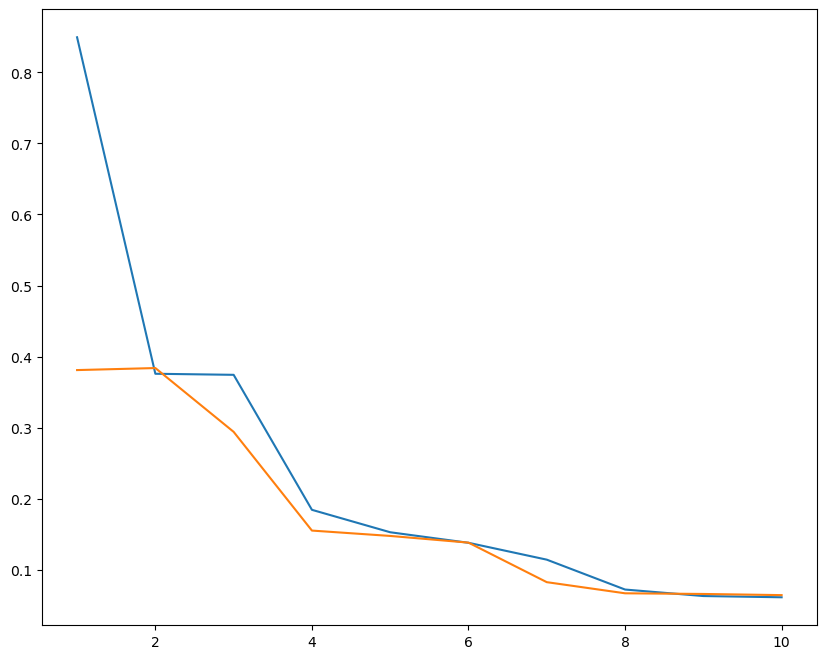

In [29]:
# Plot results
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(trainingEpoch_loss)+1),trainingEpoch_loss, label='Training Loss')
plt.plot(range(1,len(validationEpoch_loss)+1),validationEpoch_loss,label='Validation Loss')

In [ ]:
# Predictions

In [ ]:
preds = []
for batch, (X,y) in enumerate(dg_valid):
    Xt = torch.as_tensor(X).to(device)
    yt = torch.as_tensor(y).to(device)
    pred_val = model1(Xt)
    preds.append(pred_val.cpu().detach().numpy())